# LSTM Autoencoder for Tourist Anomaly Detection

This notebook trains an LSTM-based autoencoder model for detecting anomalies in tourist behavior sequences using unsupervised learning.


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow version: {tf.__version__}")


TensorFlow version: 2.18.0


In [2]:
# Load and prepare data
df = pd.read_csv('../data/tourism_anomaly_dataset.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Feature engineering
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek

# Encode categorical
le_user = LabelEncoder()
le_route = LabelEncoder()
df['user_id_encoded'] = le_user.fit_transform(df['user_id'].astype(str))
df['planned_route_id'] = df['planned_route_id'].astype(str).fillna('None')
df['route_id_encoded'] = le_route.fit_transform(df['planned_route_id'])

# Select features
feature_cols = [
    'latitude', 'longitude', 'speed_mps', 'distance_from_route_m',
    'is_checkin', 'battery_percent', 'signal_strength',
    'is_emergency_action', 'inactivity_minutes',
    'hour', 'day_of_week', 'user_id_encoded', 'route_id_encoded'
]

X = df[feature_cols].copy()
y = (df['anomaly_type'].notna()).astype(int)  # Binary: anomaly or not

print(f"Dataset shape: {X.shape}")
print(f"Anomaly rate: {y.mean():.2%}")


Dataset shape: (5000, 13)
Anomaly rate: 20.62%


In [3]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Save scaler for inference
import joblib
joblib.dump(scaler, '../data/scaler_lstm.pkl')
print("✅ Scaler saved!")


✅ Scaler saved!


In [4]:
# Create sequences for LSTM (sliding window)
def create_sequences(data, seq_length=10):
    sequences = []
    for i in range(len(data) - seq_length + 1):
        sequences.append(data[i:i+seq_length])
    return np.array(sequences)

seq_length = 10
X_seq = create_sequences(X_scaled, seq_length)

# Split data (use normal data for training, keep anomalies for testing)
normal_mask = y == 0
X_normal = X_scaled[normal_mask]
X_anomaly = X_scaled[~normal_mask]

# Create sequences for normal and anomaly data
X_normal_seq = create_sequences(X_normal, seq_length)
X_anomaly_seq = create_sequences(X_anomaly, seq_length)

# Split normal data for training/validation
X_train_seq, X_val_seq = train_test_split(
    X_normal_seq, test_size=0.2, random_state=42
)

print(f"Training sequences (normal): {X_train_seq.shape}")
print(f"Validation sequences (normal): {X_val_seq.shape}")
print(f"Anomaly sequences (test): {X_anomaly_seq.shape}")


Training sequences (normal): (3168, 10, 13)
Validation sequences (normal): (792, 10, 13)
Anomaly sequences (test): (1022, 10, 13)


In [5]:
# Define LSTM Autoencoder architecture
input_dim = X_train_seq.shape[2]  # Number of features
latent_dim = 32

# Encoder
encoder_input = layers.Input(shape=(seq_length, input_dim))
encoder_lstm1 = layers.LSTM(64, return_sequences=True)(encoder_input)
encoder_lstm2 = layers.LSTM(32, return_sequences=False)(encoder_lstm1)
encoder_output = layers.Dense(latent_dim, activation='relu')(encoder_lstm2)

# Decoder
decoder_repeat = layers.RepeatVector(seq_length)(encoder_output)
decoder_lstm1 = layers.LSTM(32, return_sequences=True)(decoder_repeat)
decoder_lstm2 = layers.LSTM(64, return_sequences=True)(decoder_lstm1)
decoder_output = layers.TimeDistributed(layers.Dense(input_dim))(decoder_lstm2)

# Autoencoder
autoencoder = models.Model(encoder_input, decoder_output)
autoencoder.compile(optimizer='adam', loss='mse', metrics=['mae'])

autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10, 13)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 10, 64)         │        19,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 10, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 10, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 10, 13)         │           845 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,437 (263.43 KB)

 Trainable params: 67,437 (263.43 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Train the autoencoder
history = autoencoder.fit(
    X_train_seq, X_train_seq,  # Input = Target (reconstruction)
    epochs=50,
    batch_size=32,
    validation_data=(X_val_seq, X_val_seq),
    verbose=1,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5)
    ]
)


Epoch 1/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 0.5853 - mae: 0.6021 - val_loss: 0.4944 - val_mae: 0.5188 - learning_rate: 0.0010
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.4872 - mae: 0.5109 - val_loss: 0.4732 - val_mae: 0.4986 - learning_rate: 0.0010
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.4678 - mae: 0.4940 - val_loss: 0.4600 - val_mae: 0.4871 - learning_rate: 0.0010
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.4552 - mae: 0.4834 - val_loss: 0.4491 - val_mae: 0.4768 - learning_rate: 0.0010
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.4468 - mae: 0.4745 - val_loss: 0.4442 - val_mae: 0.4722 - learning_rate: 0.0010
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.4399 - mae: 0.4681 - val_loss: 0.4396 - val_mae: 0.4662 - learning_rate: 0.0010
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.4369 - mae: 0.4645 - val_loss: 0.4364 - val_mae: 0.4637 - learning_rate: 0.0010
Epoch 8/50
9

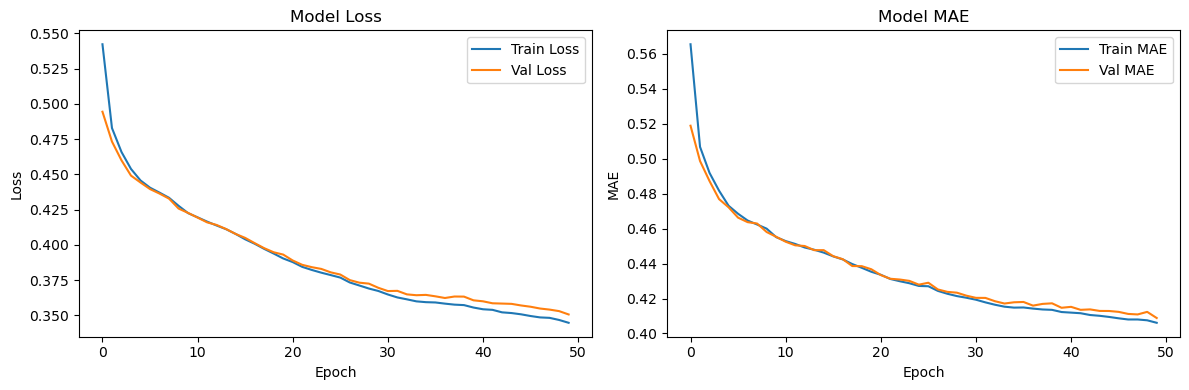

In [7]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()
plt.show()


Reconstruction error threshold: 0.4353
Normal data errors - Mean: 0.3428, Max: 0.5807
Anomaly data errors - Mean: 2.2615, Max: 4.2148


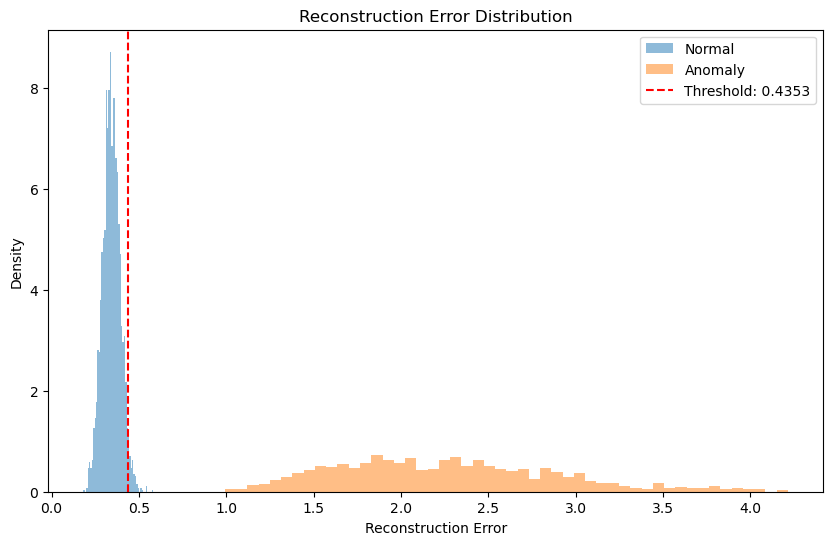

In [8]:
# Evaluate: Calculate reconstruction errors
train_pred = autoencoder.predict(X_train_seq, verbose=0)
val_pred = autoencoder.predict(X_val_seq, verbose=0)
anomaly_pred = autoencoder.predict(X_anomaly_seq, verbose=0)

train_errors = np.mean(np.square(X_train_seq - train_pred), axis=(1, 2))
val_errors = np.mean(np.square(X_val_seq - val_pred), axis=(1, 2))
anomaly_errors = np.mean(np.square(X_anomaly_seq - anomaly_pred), axis=(1, 2))

# Determine threshold (e.g., 95th percentile of validation errors)
threshold = np.percentile(val_errors, 95)
print(f"Reconstruction error threshold: {threshold:.4f}")
print(f"Normal data errors - Mean: {train_errors.mean():.4f}, Max: {train_errors.max():.4f}")
print(f"Anomaly data errors - Mean: {anomaly_errors.mean():.4f}, Max: {anomaly_errors.max():.4f}")

# Visualize error distribution
plt.figure(figsize=(10, 6))
plt.hist(train_errors, bins=50, alpha=0.5, label='Normal', density=True)
plt.hist(anomaly_errors, bins=50, alpha=0.5, label='Anomaly', density=True)
plt.axvline(threshold, color='r', linestyle='--', label=f'Threshold: {threshold:.4f}')
plt.xlabel('Reconstruction Error')
plt.ylabel('Density')
plt.title('Reconstruction Error Distribution')
plt.legend()
plt.show()


In [9]:
# Save model and threshold
autoencoder.save('../data/model_lstm_autoencoder.h5')
np.save('../data/anomaly_threshold.npy', threshold)
print("✅ Model and threshold saved!")

# Save feature names
import json
with open('../data/feature_names_lstm.json', 'w') as f:
    json.dump(feature_cols, f)
print("✅ Feature names saved!")


✅ Model and threshold saved!
✅ Feature names saved!
